In [1]:
# prepare data and arrange features
import pandas as pd
import numpy as np
file_path = r'data.xlsx'
data = pd.read_excel(file_path)
# drop the "Index" column
data = data.drop('Index', axis=1)

features = data.columns
numeric_features = ['Age','Years of Work Experience','Years of Work Experience at Current Institution', 'Institution Level', 'Number of Children Under 12',
                    'First Degree', 'Highest Degree', 'Monthly Night Shift Frequency', 'Monthly Take-home Income',
                    'Number of Specialist Trainings/Continuing Education Attended', 'Average Number of Clinical Teaching/Training Activities Participated in per Year', 
                    'Degree of Application of Specialist Skills in Subsequent Clinical Practice']
categorical_features = ['Gender', 'Job Title', 'Position', 
            'Employment Type',  
            'Whether Obtained Specialist Qualification Certificate and the Specialist Field',
            'Whether Working in a Specialist Nursing Outpatient Clinic', 
            'Whether Undertaken Research Projects in the Past Three Years', 'Whether Role Stress is High', 
            'Whether Empathy Level is High', 'Whether Level of Happiness is High', 'Whether Satisfaction with Performance Distribution is High']
target = 'In Your Current Medical Institution, Your Inclination to Change Position in the Next 1-10 Years'
# ensure numeric_features is a subset of features
assert(all(elem in features for elem in numeric_features))
# ensure categorical_features is a subset of features
assert(all(elem in features for elem in categorical_features))
# ensure each feature is either in numeric_features or categorical_features, or it is the target
assert(all(elem in numeric_features or elem in categorical_features or elem == target for elem in features))
# ensure there is no duplicates among the three categories
assert(all(elem not in numeric_features for elem in categorical_features))
assert(all(elem not in categorical_features for elem in numeric_features))
assert(target not in numeric_features + categorical_features)

# X is all but target
X = data[numeric_features + categorical_features]
y = data[target]

# X = X.values
# y = y.values
# print(X)
# print(y)

In [2]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [3]:
print("samples with y = 1: ", sum(y==1))
print("samples with y = 0: ", sum(y==0))
print("samples with y = 1 in train: ", sum(y_train==1))
print("samples with y = 0 in train: ", sum(y_train==0))
print("samples with y = 1 in test: ", sum(y_test==1))
print("samples with y = 0 in test: ", sum(y_test==0))

samples with y = 1:  367
samples with y = 0:  104
samples with y = 1 in train:  293
samples with y = 0 in train:  83
samples with y = 1 in test:  74
samples with y = 0 in test:  21


In [4]:
# define preprocessing procedures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer

preproc_scale_onehot = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])
preproc_scale = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)
preproc_onehot = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)
feature_selection_logistic = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear'))
feature_selection_random_forest = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
smote = SMOTE(random_state=42)

In [5]:
# cross-validation template, see the code blocks below for usage
from sklearn.model_selection import RandomizedSearchCV
import optuna
from optuna import trial as optuna_trial
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer

# just for intellisense purposes
suggest_float = 'suggest_float'
suggest_int = 'suggest_int'
suggest_categorical = 'suggest_categorical'

metric = 'roc_auc'
optuna.logging.set_verbosity(optuna.logging.ERROR)
def cross_validate_model(model_class, model_parameters, fit_parameters, n_trials = 100): # [hyperparameter_name, functionname, (function args)
    def objective(trial: optuna_trial.Trial):
        # print(f"Running trial {trial.number}")
        try:
            # Define the pipeline
            adopt_scalar = trial.suggest_categorical('Adopt StandardScalar for numeric features', [True, False])
            adopt_onehot = trial.suggest_categorical('Adopt OneHotEncoder for categorical features', [True, False])
            adopt_selection = trial.suggest_categorical('Adopt feature selection', ['None', 'LogisticRegression', 'RandomForest'])
            # adopt_SMOTE = trial.suggest_categorical('Adopt oversampling using SMOTE', [True, False])
            # pipeline steps
            steps = []
            if adopt_scalar and adopt_onehot: steps.append(('onehot_and_scalar', preproc_scale_onehot))
            else:
                if adopt_scalar:
                    assert(not adopt_onehot)
                    steps.append(('scalar', preproc_scale))
                if adopt_onehot:
                    assert(not adopt_scalar)
                    steps.append(('onehot', preproc_onehot))
            # if adopt_selection: steps.append(('selection', feature_selection))
            if adopt_selection == 'LogisticRegression': steps.append(('selection', feature_selection_logistic))
            elif adopt_selection == 'RandomForest': steps.append(('selection', feature_selection_random_forest))
            # SMOTE must be used
            steps.append(('smote', smote))
            model_args = {}
            for model_parameter in model_parameters:
                parameter_name, function_name, function_args = model_parameter
                func = getattr(trial, function_name)
                function_kwargs = {'log': True} if function_name == suggest_float else {}
                if function_args[0] == "hidden_layer_sizes":
                    # transform a scalar to a length 1 tuple for the hidden_layer_sizes parameter for MLPClassifier
                    model_args.update({parameter_name: (func(*function_args, **function_kwargs),)})
                else:
                    model_args.update({parameter_name: func(*function_args, **function_kwargs)})
            
            fit_args = {}
            for fit_parameter in fit_parameters:
                parameter_name, function_name, function_args = fit_parameter
                func = getattr(trial, function_name)
                function_kwargs = {'log': True} if function_name == suggest_float else {}
                fit_args.update({'classifier__' + parameter_name: func(*function_args, **function_kwargs)})
            model = model_class(**model_args)   
            # model._estimator_type = "classifier"
            # print(model._estimator_type)
            
            to_numpy = FunctionTransformer(lambda x: x.values if hasattr(x, "values") else x, validate=False)
            steps.append(('to_numpy', to_numpy))

            steps.append(('classifier', model))
            
            pipeline = ImbPipeline(steps=steps)
            # print(pipeline.predict_proba(X_train[:5]))  # should return probabilities
            # print(hasattr(pipeline, 'predict_proba'))  # should be True
            # Perform cross-validation
            # score = cross_val_score(pipeline, X_train, y_train, n_jobs=-1, cv=10, scoring=metric)
            score = cross_val_score(pipeline, X_train, y_train, cv=10, scoring=metric, params=fit_args, n_jobs=-1)
            mean_score = score.mean()
            return mean_score
        except Exception as e:
            print(f"An exception occurred: {e}")
            raise e
    
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
    # print(f"Total trials: {len(study.trials)}")
    # print(f"Completed trials: {len([t for t in study.trials if t.state.name == 'COMPLETE'])}")
    # print(f"Failed trials: {len([t for t in study.trials if t.state.name == 'FAIL'])}")

    # study.optimize(objective, n_trials=n_trials, show_progress_bar=True, n_jobs=-1)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True, catch=(Exception,))

    trial = study.best_trial
    print(f'{model_class.__name__} Cross-Validation Performance:')
    print("Best trial:")
    print(f"  Value: {trial.value}")
    print("  Best hyperparameters:")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

c:\Users\luo20\Desktop\New Volume D\Desktop\nurse_transfer\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# plays a sound effect when the task is finished so that we can get notified
import os
def play_finished_hint():
    os.system('powershell.exe -c "(New-Object Media.SoundPlayer \\"C:\\\\Windows\\\\Media\\\\ok.wav\\").PlaySync()"')
play_finished_hint()

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils._tags import InputTags
class SklearnCompatibleTabNetClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.tabnet = TabNetClassifier(**kwargs)

    def __sklearn_tags__(self):
        class DummyTag:
            def __init__(self):
                self.estimator_type = 'classifier'
                self.input_tags=InputTags(one_d_array=False, two_d_array=True, three_d_array=False, sparse=True, categorical=False, string=False, dict=False, positive_only=False, allow_nan=False, pairwise=False)
                self.requires_fit=True
        return DummyTag()

    def fit(self, X, y, **fit_params):
        self.tabnet.fit(
            X, y, 
            **fit_params
        )
        self.classes_ = np.unique(y)  # required by scikit-learn
        return self

    def predict(self, X):
        return self.tabnet.predict(X)

    def predict_proba(self, X):
        return self.tabnet.predict_proba(X)


In [11]:
# Example hyperparameter suggestions for TabNetClassifier
model_parameters = [
    # ('n_d', suggest_categorical, ['n_d', [8, 12, 16]]),
    # ('n_a', suggest_categorical, ['n_a', [8, 12, 16]]),
    ('n_d', suggest_categorical, ['n_d', [4, 6, 8]]),
    ('n_a', suggest_categorical, ['n_a', [4, 6, 8]]),
    ('n_steps', suggest_categorical, ['n_steps', [3, 4, 5]]),
    ('gamma', suggest_float, ['gamma', 1.0, 1.5]),
    ('lambda_sparse', suggest_float, ['lambda_sparse', 1e-4, 1e-3]),
    ('momentum', suggest_float, ['momentum', 0.02, 0.2]),
    ('clip_value', suggest_float, ['clip_value', 1.0, 2.0]),
    ('scheduler_params', suggest_categorical, ['scheduler_params', [None]]),
    ('verbose', suggest_categorical, ['verbose', [0]]),
    ('device_name', suggest_categorical, ['device_name', ['xpu']]),
]
fit_parameters = [
    ('batch_size', suggest_int, ['batch_size', 32, 64]),
    
    ('virtual_batch_size', suggest_int, ['virtual_batch_size', 16, 32]),
    ('max_epochs', suggest_int, ['max_epochs', 10, 20]),
]

cross_validate_model(SklearnCompatibleTabNetClassifier, model_parameters, fit_parameters, 100)
play_finished_hint()

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\luo20\Desktop\New Volume D\Desktop\nurse_transfer\venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
Best trial: 0. Best value: 0.638515:   1%|          | 1/100 [00:11<18:54, 11.46s/it]c:\Users\luo20\Desktop\New Volume D\Desktop\nurse_transfer\venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
Best trial: 0. Best value: 0.638515:   2%|▏         | 2/100 [00:15<11:31,  7.05s/it]c:\Users\luo20\Desktop\New Volume D\Desktop\nurse_transfer\venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
Best trial: 0. Best value: 0.638515:   3%|▎         | 3/100 [00:18<08:41,  5.37s/it]c:\Users\luo20\Desktop\New Volume D\Desktop\nurse_transfer\venv\Lib\site-packages\pytorch_tabnet\abstract_model.py:

SklearnCompatibleTabNetClassifier Cross-Validation Performance:
Best trial:
  Value: 0.6804070881226053
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: None
    n_d: 4
    n_a: 6
    n_steps: 3
    gamma: 1.140937725851713
    lambda_sparse: 0.0005365450324352025
    momentum: 0.08681354023778796
    clip_value: 1.849599281574283
    scheduler_params: None
    verbose: 0
    device_name: xpu
    batch_size: 47
    virtual_batch_size: 18
    max_epochs: 17


In [12]:
# RandomForestClassifier cross-validation task
from sklearn.ensemble import RandomForestClassifier
model_parameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 10, 1000]),
    ('max_depth', suggest_int, ['max_depth', 1, 30]),
    ('min_samples_split', suggest_int, ['min_samples_split', 2, 20]),
    ('min_samples_leaf', suggest_int, ['min_samples_leaf', 1, 10]),
    ('max_features', suggest_categorical, ['max_features', ['log2', 'sqrt']]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(RandomForestClassifier, model_parameters, dict(), 100)
play_finished_hint()

Best trial: 2. Best value: 0.701135: 100%|██████████| 100/100 [03:39<00:00,  2.19s/it]


RandomForestClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7011350574712644
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: None
    n_estimators: 950
    max_depth: 29
    min_samples_split: 17
    min_samples_leaf: 4
    max_features: sqrt
    random_state: 42


In [13]:
# XGBoost cross-validation task
import xgboost as xgb
model_parameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 50, 1000]),
    ('max_depth', suggest_int, ['max_depth', 3, 20]),
    ('learning_rate', suggest_float, ['learning_rate', 0.005, 0.2]),
    ('subsample', suggest_float, ['subsample', 0.5, 1.0]),
    ('colsample_bytree', suggest_float, ['colsample_bytree', 0.3, 1.0]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(xgb.XGBClassifier, model_parameters, dict(), 100)
play_finished_hint()

Best trial: 19. Best value: 0.670388: 100%|██████████| 100/100 [01:11<00:00,  1.39it/s]


XGBClassifier Cross-Validation Performance:
Best trial:
  Value: 0.6703879310344828
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: True
    Adopt feature selection: None
    n_estimators: 737
    max_depth: 8
    learning_rate: 0.0054692231235925395
    subsample: 0.7821256461460095
    colsample_bytree: 0.37130317642380123
    random_state: 42


In [14]:
# MLPClassifier cross-validation task
from sklearn.neural_network import MLPClassifier
model_parameters=[# [hyperparameter_name, functionname, (function args)
    ('hidden_layer_sizes', suggest_categorical, ['hidden_layer_sizes', [200, 100, 50, 20, 5]]),
    ('activation', suggest_categorical, ['activation', ['identity', 'logistic', 'tanh', 'relu']]),
    ('solver', suggest_categorical, ['solver', ['lbfgs', 'sgd', 'adam']]),
    ('alpha', suggest_float, ['alpha', 0.0001, 0.01]),
    ('learning_rate', suggest_categorical, ['learning_rate',['constant', 'invscaling', 'adaptive']]),
    ('random_state', suggest_categorical, ['random_state', [42]]),
    ('max_iter', suggest_int, ['max_iter', 100, 200])
]
cross_validate_model(MLPClassifier, model_parameters, dict(), 100)
play_finished_hint()

Best trial: 56. Best value: 0.690536: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


MLPClassifier Cross-Validation Performance:
Best trial:
  Value: 0.690536398467433
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: None
    hidden_layer_sizes: 5
    activation: identity
    solver: lbfgs
    alpha: 0.0018328226371899805
    learning_rate: constant
    random_state: 42
    max_iter: 191


In [15]:
# LGBMClassifier cross-validation task
import lightgbm as lgb
model_parameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 20, 1000]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 0.2]),
    ('num_leaves', suggest_int, ['num_leaves', 31, 100]),
    ('max_depth', suggest_int, ['max_depth', 2, 20]),
    ('min_data_in_leaf', suggest_int, ['min_data_in_leaf', 1, 50]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(lgb.LGBMClassifier, model_parameters, dict(), 100)
play_finished_hint()

Best trial: 31. Best value: 0.665196: 100%|██████████| 100/100 [09:23<00:00,  5.63s/it]


LGBMClassifier Cross-Validation Performance:
Best trial:
  Value: 0.6651963601532567
  Best hyperparameters:
    Adopt StandardScalar for numeric features: False
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: None
    n_estimators: 296
    learning_rate: 0.014247412064304842
    num_leaves: 79
    max_depth: 13
    min_data_in_leaf: 44
    random_state: 42


In [16]:
# AdaBoostClassifier cross-validation task
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
model_parameters=[# [hyperparameter_name, functionname, (function args)
    ('n_estimators', suggest_int, ['n_estimators', 50, 500]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 1.0]),
    ('algorithm', suggest_categorical, ['algorithm', ['SAMME']]),
    ('random_state', suggest_categorical, ['random_state', [42]]),
]
cross_validate_model(AdaBoostClassifier, model_parameters, dict(), 100)
play_finished_hint()

Best trial: 80. Best value: 0.68069: 100%|██████████| 100/100 [04:11<00:00,  2.52s/it]


AdaBoostClassifier Cross-Validation Performance:
Best trial:
  Value: 0.6806896551724138
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: LogisticRegression
    n_estimators: 408
    learning_rate: 0.025307814358249456
    algorithm: SAMME
    random_state: 42


In [17]:
# CatBoostClassifier cross-validation task
from catboost import CatBoostClassifier
model_parameters=[# [hyperparameter_name, functionname, (function args)
    ('iterations', suggest_int, ['iterations', 50, 200]),
    ('learning_rate', suggest_float, ['learning_rate', 0.01, 0.2]),
    ('depth', suggest_int, ['depth', 4, 8]),
    ('l2_leaf_reg', suggest_int, ['l2_leaf_reg', 1, 10]),
    ('early_stopping_rounds', suggest_int, ['early_stopping_rounds', 5, 20]),
    ('verbose', suggest_categorical, ['verbose', [0]]),
    ('random_state', suggest_categorical, ['random_state', [42]])
]
cross_validate_model(CatBoostClassifier, model_parameters, dict(), 100)
play_finished_hint()

Best trial: 53. Best value: 0.706729: 100%|██████████| 100/100 [03:02<00:00,  1.82s/it]


CatBoostClassifier Cross-Validation Performance:
Best trial:
  Value: 0.7067289272030651
  Best hyperparameters:
    Adopt StandardScalar for numeric features: True
    Adopt OneHotEncoder for categorical features: False
    Adopt feature selection: LogisticRegression
    iterations: 99
    learning_rate: 0.014315750667998532
    depth: 8
    l2_leaf_reg: 6
    early_stopping_rounds: 15
    verbose: 0
    random_state: 42


In [22]:
# train and test the model based on the best model and best hyperparameters
# from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    confusion_matrix
)

# MLPClassifier has the best performance in the cross-validation section
clf = CatBoostClassifier(
    iterations=99,
    learning_rate=0.0143,
    depth=8,
    l2_leaf_reg=6,
    early_stopping_rounds=15,
    verbose=0,
    random_state=42,
)
# adopts one-hot encoder and SMOTE
# preproc_onehot = ColumnTransformer(
#     transformers=[
#         ('num', 'passthrough', numeric_features),  # Numerical features first
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ]
# )
# preproc_scale_onehot = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numeric_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ]
# )

preproc_scale = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

feature_selection = SelectFromModel(LogisticRegression(penalty="l1", solver='liblinear', random_state=43))
smote = SMOTE(random_state=42)
pipeline = Pipeline(steps=[
    ('scale', preproc_scale)
])


X_train_preprocessed = pipeline.fit_transform(X_train, y_train)
X_train_smoted, y_train_smoted = smote.fit_resample(X_train_preprocessed, y_train)
clf.fit(X_train_smoted, y_train_smoted)
# clf.fit(X_train_preprocessed, y_train)
X_test_transformed = pipeline.transform(X_test)
y_pred_proba = clf.predict_proba(X_test_transformed)[:,1]

encoder = pipeline.named_steps['scale'].named_transformers_['cat']
one_hot_feature_names = encoder.get_feature_names_out(categorical_features)
# Combine original and one-hot feature names
all_feature_names = numeric_features + list(one_hot_feature_names)
# make sure the one-hot-transformed feature name dimesion matches all_feature_names
# X_onehot = preproc_onehot.fit_transform(X_train)
# assert(X_onehot.shape[1] == len(all_feature_names))

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)

# Convert probabilities to binary predictions (using 0.5 as threshold)
threshold = 0.5
y_pred = (y_pred_proba >= threshold).astype(int)

# print(y_pred)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred)

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate Sensitivity (Recall)
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

# Calculate Specificity
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Calculate Youden's J Score
youden_j = sensitivity + specificity - 1

# Print the results
print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Youden's J Score: {youden_j:.4f}")


AUC: 0.7658
F1 Score: 0.8533
Accuracy: 0.7684
Sensitivity: 0.8649
Specificity: 0.4286
Youden's J Score: 0.2934


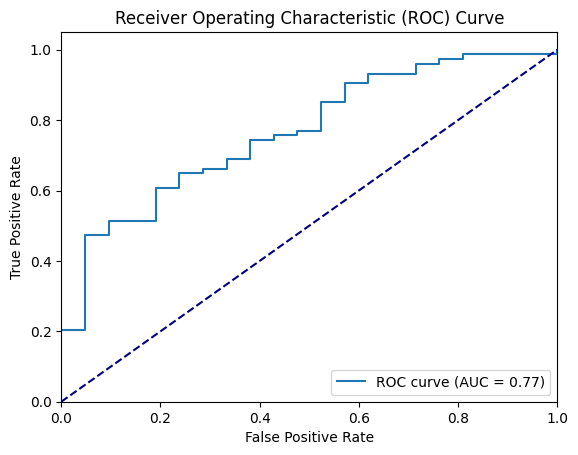

In [23]:
# plot the ROC curve
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Use the optimal preprocessing procedures (no feature selection, resample with SMOTE)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
# Step 6: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


100%|██████████| 95/95 [00:07<00:00, 13.21it/s]


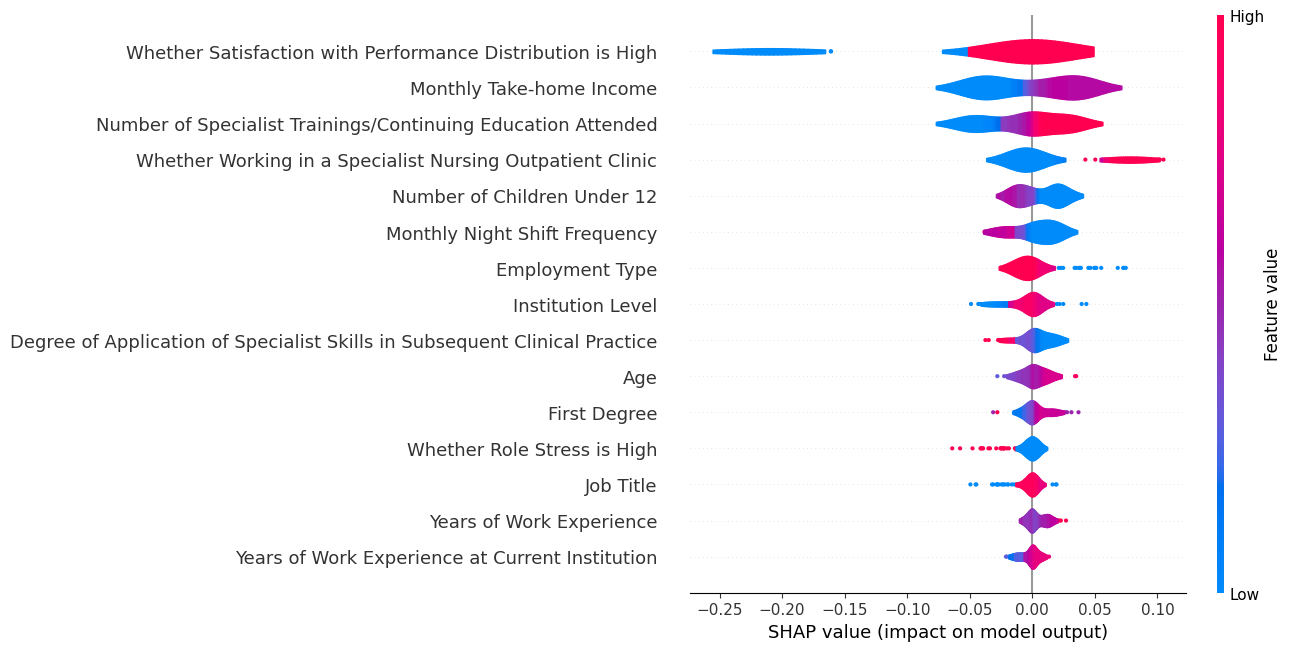

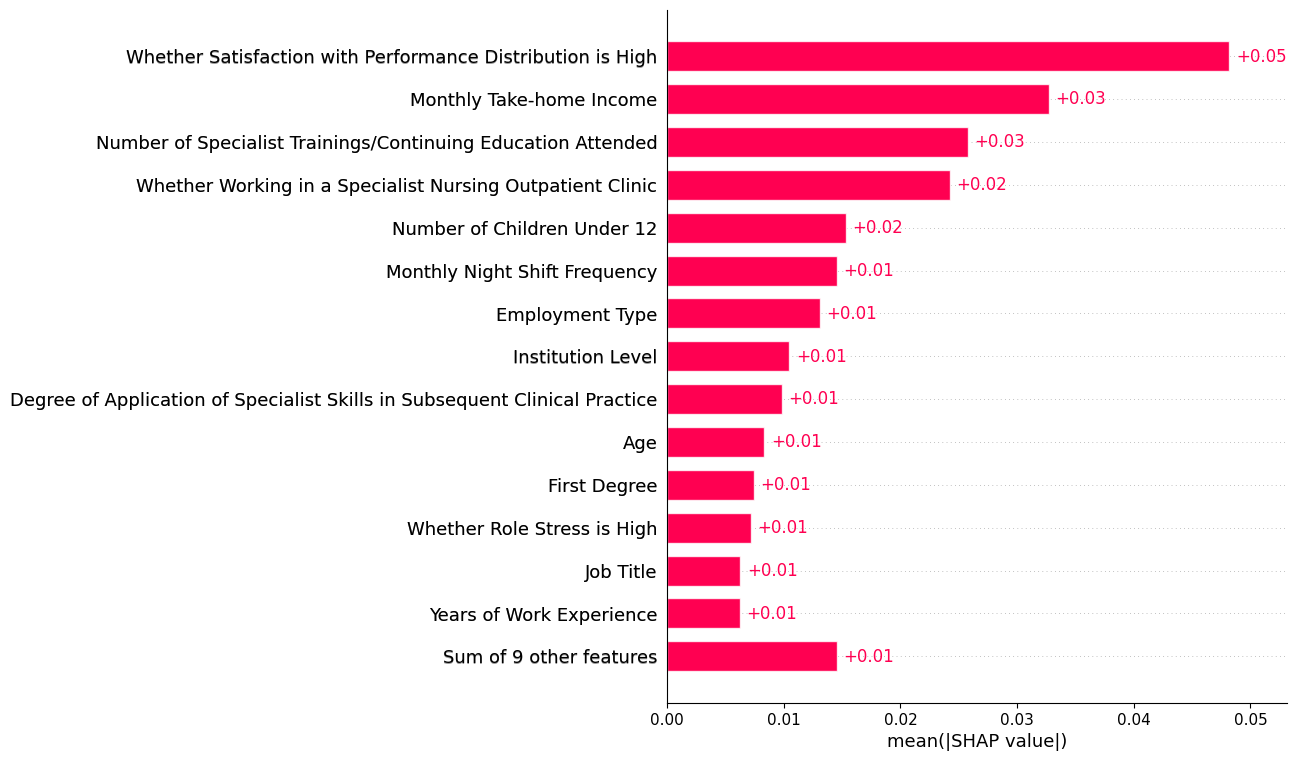

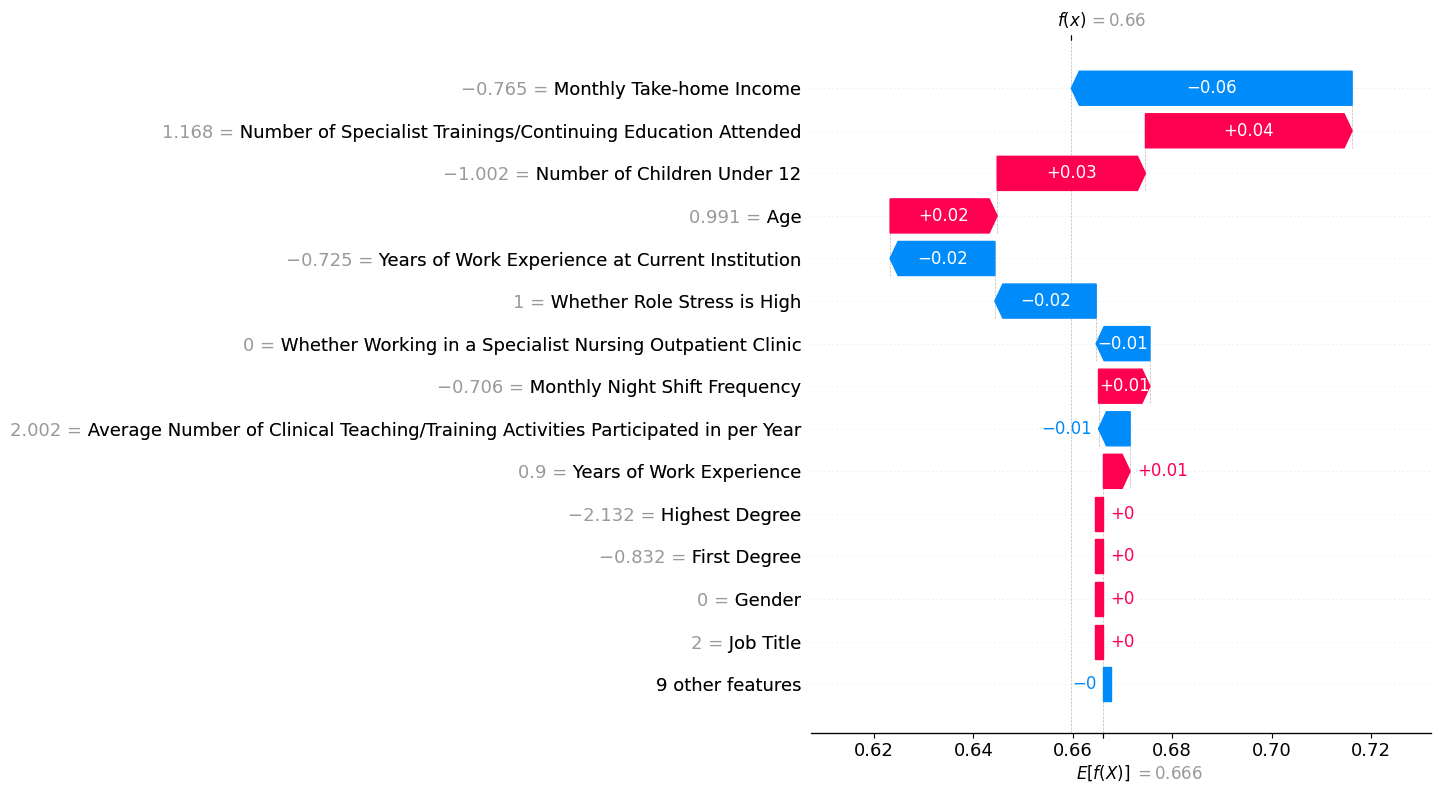

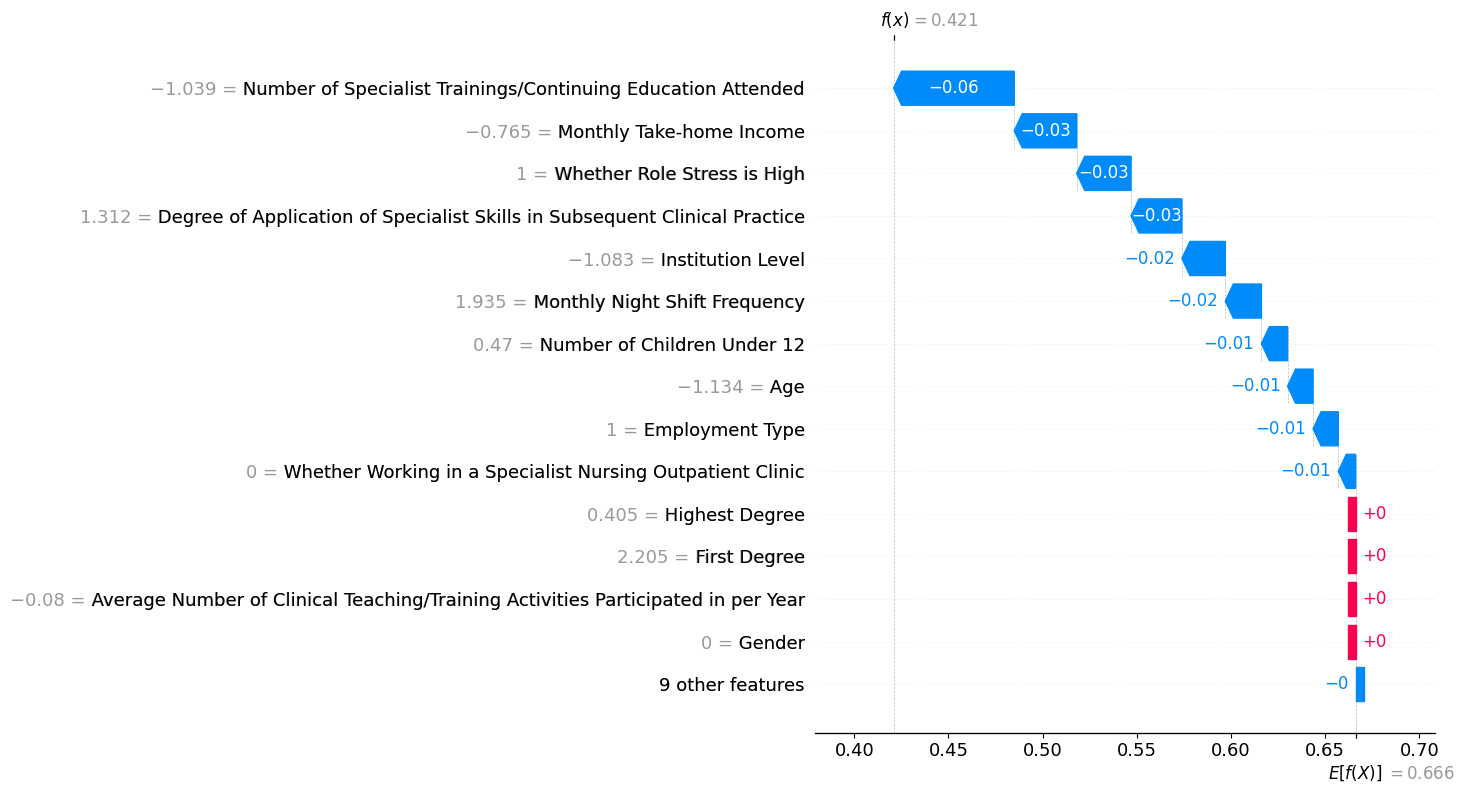

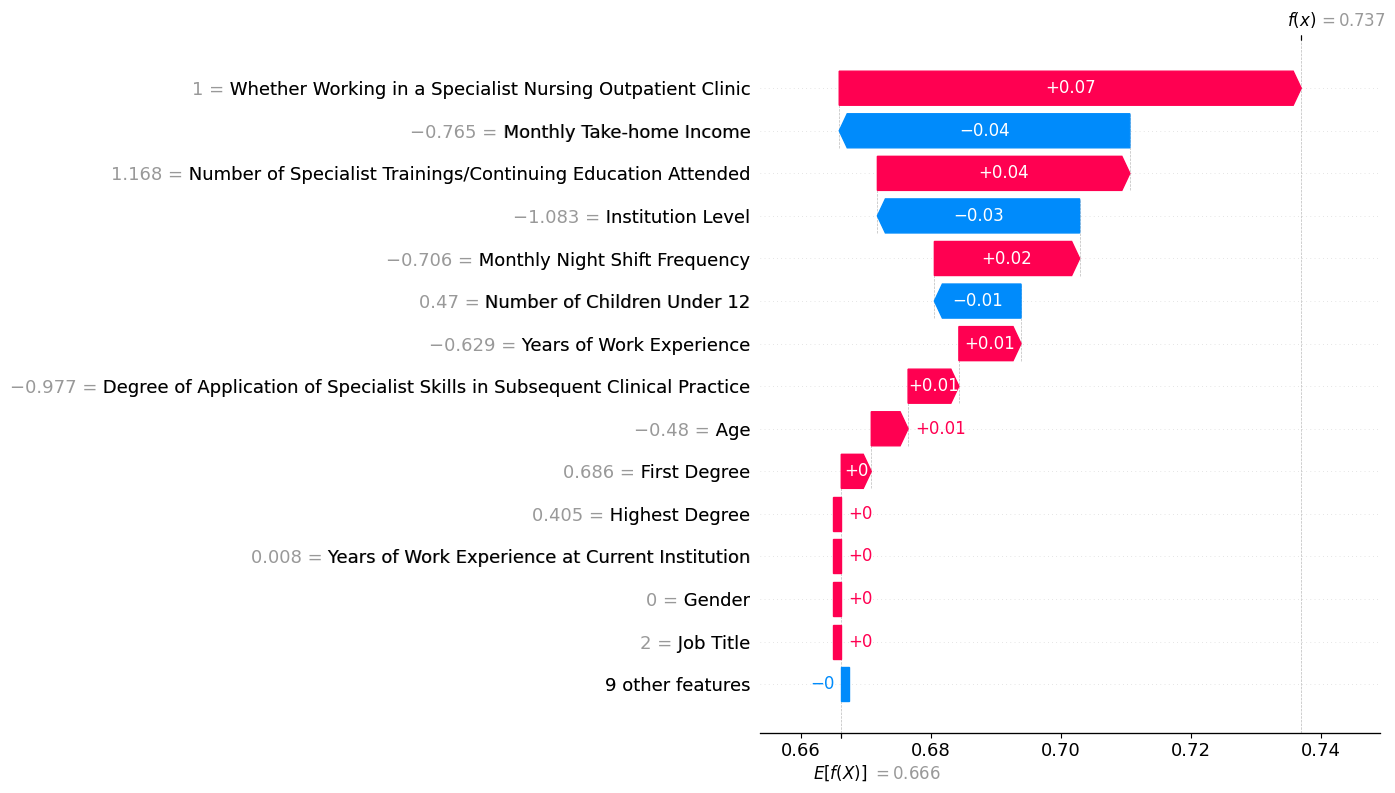

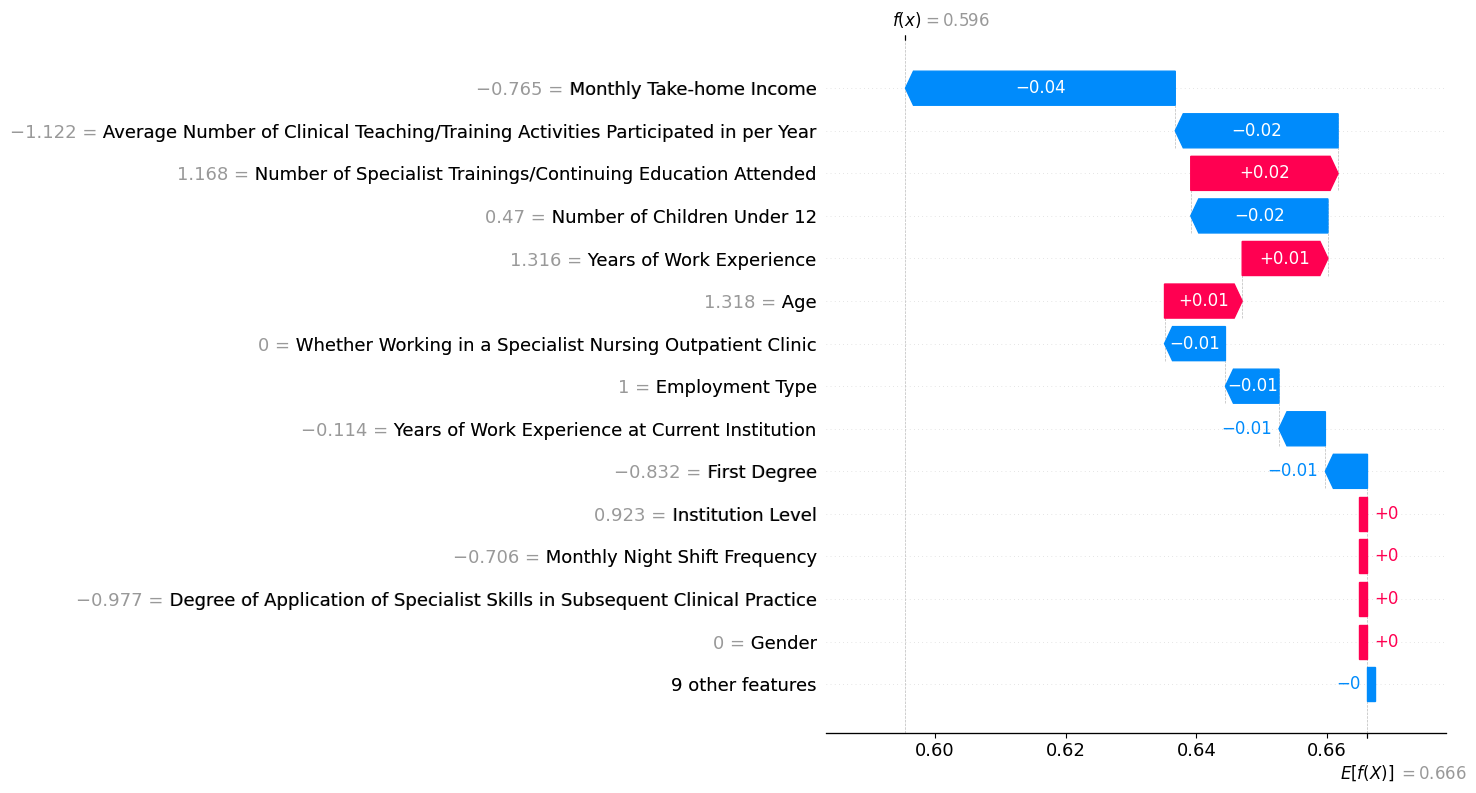

In [24]:
# plot the SHAP plots
import shap
import matplotlib.pyplot as plt
# %matplotlib qt

X_train_sampled = shap.sample(X_train_preprocessed, 10)
explainer = shap.KernelExplainer(clf.predict_proba, X_train_sampled, feature_names=all_feature_names)

X_test_preprocessed = pipeline.transform(X_test)
# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_preprocessed)

explanation = shap.Explanation(values=shap_values[:,:,1], 
                                base_values=explainer.expected_value[1], 
                                data=X_test_preprocessed, 
                                feature_names=all_feature_names)
shap.plots.violin(explanation, max_display=15)
shap.plots.bar(explanation, max_display=15)
shap.plots.waterfall(explanation[0], max_display=15)
shap.plots.waterfall(explanation[1], max_display=15)
shap.plots.waterfall(explanation[2], max_display=15)
shap.plots.waterfall(explanation[3], max_display=15)
